In [27]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import scipy.ndimage as sc

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

pd.options.display.max_columns = None

TRAIN = pd.read_csv("../datasources/mnsit/train.csv", delimiter=',') #, skiprows=1)
TEST = pd.read_csv("../datasources/mnsit/test.csv", delimiter=',') #, skiprows=1)
X_TRAIN = TRAIN.copy()
X_TEST = TEST.copy()
y = TRAIN.label
del X_TRAIN["label"]

# Fonction d'export pour kaggle
def exportKaggle(algo):
    p_test = algo.predict(X_TEST)
    result = pd.DataFrame(X_TEST.index + 1, columns=['ImageId'])
    pred = pd.DataFrame(p_test, columns=['Label'])
    result = result.join(pred)
    fichier = "./data/result_" + str(datetime.datetime.now()).replace(":", "-").replace(" ", "_")
    result.to_csv(fichier, columns=["ImageId", "Label"], index=False)
    
# returns the image in digit (28x28)
# fromIndex = 0 if no labels 1 else
def getImageMatriceDigit(dataset, rowIndex, fromIndex):
    return dataset.iloc[rowIndex, fromIndex:].values.reshape(28,28)

# returns the image matrix in one row
# fromIndex = 0 if no labels 1 else
def getImageLineDigit(dataset, rowIndex, fromIndex):
    return dataset.iloc[rowIndex, fromIndex:]

# display an image defined in the data given (train/test)
def displayImageFromData(data, row, fromIndex):
    imgDigitMatrice = getImageMatriceDigit(data, row, fromIndex)
    displayImage(imgDigitMatrice)

# display an image from the Matrix 28:28
def displayImage(image):
    plt.imshow(image, cmap=matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()

# shift the image
def shiftImage(imageMatrix, shiftConfig):
    return sc.shift(imageMatrix, shiftConfig, cval=0)

# convert an image 28:28 in one matrix row
def convertImageInRow(_img):
    return pd.DataFrame(_img.reshape(1,784), 
                        columns=["pixel" + str(x) for x in range(784)])

# dark or white / wash the pixel
def addNoise(val, thresoldMin, thresoldMax):
    if (val < thresoldMin):
        return 0
    elif val > thresoldMax:
        return val - 40
    else:
        return val
    
# Clean a global dataset 
def noiseImage(dataset, thresoldMin, thresoldMax):
    for i in range(dataset.shape[1]):
        dataset['pixel' + str(i)] = [addNoise(x, thresoldMin, thresoldMax) for x in dataset['pixel' + str(i)]]

# returns 4 images shifted from the original one
# _imageMatrix : image in a (1, 784) array
# _label : original image label
def shift4LineImages(_imageMatrix, _label):
    img = _imageMatrix.values.reshape(28,28)
    # Image shifting in 4 axes
    row1 = convertImageInRow(shiftImage(img, [0, 1]))
    row2 = convertImageInRow(shiftImage(img, [2, 0]))
    row3 = convertImageInRow(shiftImage(img, [-3, 0]))
    row4 = convertImageInRow(shiftImage(img, [0, -2]))
    # Noise images
    noiseImage(row1, 100, 200)
    noiseImage(row2, 150, 240)
    noiseImage(row3, 60, 170)
    noiseImage(row4, 90, 180)
    # Add image Label
    row1.insert(0, 'label', _label)
    row2.insert(0, 'label', _label)
    row3.insert(0, 'label', _label)
    row4.insert(0, 'label', _label)
    # returns the 4 new images
    return pd.concat([row1, row2, row3, row4], ignore_index=True)



# Extension du jeu de données d'entrainement

## Test avec une seule image (ligne N°3), c'est un quatre

Ajout de 4 images par image originale / via decalage de pixel

In [28]:
X_NEWTRAIN = pd.DataFrame()
Rangeloop = [3] 
datebefore = dateinit = datetime.datetime.now()

for rowIdx in Rangeloop:
    X_NEWTRAIN = pd.concat([X_NEWTRAIN, shift4LineImages(getImageLineDigit(TRAIN, rowIdx, 1), y[rowIdx])], ignore_index=True)
    elapsed = datetime.datetime.now() - datebefore
    print ("Elapsed: " + str(elapsed.total_seconds()) + " sec. | Index: " + str(rowIdx) + " | Shape: " + str(X_NEWTRAIN.shape))
    datebefore = datetime.datetime.now()

elapsedTotal = datetime.datetime.now() - dateinit
print ("Total Elapsed: " + str(elapsedTotal.total_seconds()) + " sec. | Global Shape: " + str(X_NEWTRAIN.shape))

Elapsed: 0.501837 sec. | Index: 3 | Shape: (4, 785)
Total Elapsed: 0.501837 sec. | Global Shape: (4, 785)


In [29]:
X_NEWTRAIN

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455

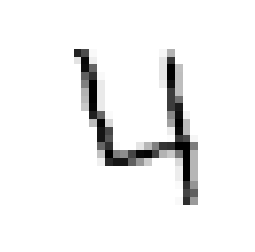

In [30]:
displayImageFromData(X_TRAIN, 3, 0)

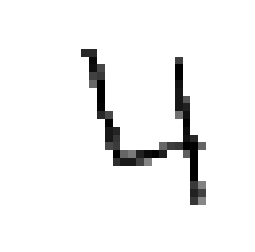

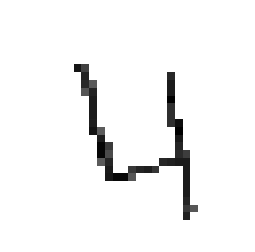

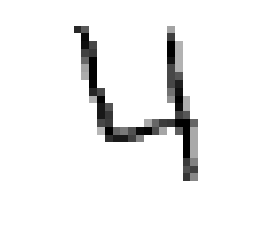

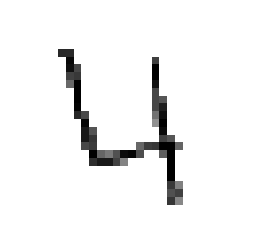

In [31]:
displayImageFromData(X_NEWTRAIN, 0, 1)
displayImageFromData(X_NEWTRAIN, 1, 1)
displayImageFromData(X_NEWTRAIN, 2, 1)
displayImageFromData(X_NEWTRAIN, 3, 1)

## Application à tout le jeu de données

In [ ]:
X_NEWTRAIN = pd.DataFrame()
Rangeloop = range(X_TRAIN.shape[0])
for rowIdx in Rangeloop:
    if (rowIdx % 100 == 0):
        print ("Index: " + str(rowIdx) + " | Shape: " + str(X_NEWTRAIN.shape))
    X_NEWTRAIN = pd.concat([X_NEWTRAIN, shift4LineImages(getImageMatriceDigit(TRAIN, rowIdx, 1), y[rowIdx])], ignore_index=True)
X_NEWTRAIN = pd.concat([X_NEWTRAIN, TRAIN], ignore_index=True)

In [6]:
X_NEWTRAIN.to_csv("./data/trainextended.csv", index=False)

# Essayons maintenant  avec un RandomForest

In [3]:
X_NEWTRAIN = pd.read_csv("./data/trainextended.csv", delimiter=',') #, skiprows=1)
y = X_NEWTRAIN.label
del X_NEWTRAIN["label"]

In [4]:
rf = RandomForestClassifier(n_estimators=1000, random_state=3, max_features=1)
rf.fit(X_NEWTRAIN, y)
print ("Score Train -->", round(rf.score(X_NEWTRAIN, y) *100,2), " %")

Score Train --> 100.0  %


In [5]:
exportKaggle(rf)

## Score Kaggle 0.97057